# Better Performance with MKL BLAS on MXNet 1.6 Deep Learning Containers

Inference speed and performance is often times one of the most crucial factors for deciding to deploy a model in a production environment. Small increases in latency can be costly, so every bit of performance boost that can be had can help the overall costs. Because of our obessesion for customers, the MXNet team has brought a solution to improve the latency for inference using MXNet 1.6 Deep learning containers. In this post, we dicuss the improvement that was made to the MXNet 1.6.0 DLC version to make use of highly optimized matrix operators. The enhancement comes in the form of compiling MXNet with a dependency on Intel MKL BLAS instead of the default, oneDNN. As one will see, the performance boost can be up to 30% in latency reduction, making this a worthwhile option for our customers to implement in their production environment. To describe and show the enhancements in more detail, we will use the MNIST dataset to briefly give context of performing inference on Amazon SageMaker. Then, we will discuss the differences between the MKL BLAS and oneDNN libraries. Lastly, we will show how to implement the enhancement in your environment so that you can take advantage of the performance boost. 

**Note: MXNet 1.7+ Deep Learning Containers have this enhancement as a default, so this solution applies to customers who don't want to change the MXNet version from 1.6.0**

## Inference on Amazon SageMaker

Amazon SageMaker makes it really easy to deploy, host and maintain models. As part of that, choosing what framework or deep learning container to use is also a matter of setting a parameter. For the remainder of this post, we will use the MNIST dataset to quickly give examples for context and to show the performance difference between the MKL BLAS library and oneDNN library. But first, here is a brief example of how to perform inference in SageMaker.

### Setup

First we define a few variables that are needed to perform operations in SageMaker

In [96]:
!pip install gluonnlp --quiet
!pip install bert --quiet
!pip install mxnet --upgrade 

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 55.0 MB 8.6 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [44]:
!pip install gluoncv --quiet

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [1]:
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.mxnet.model import MXNetModel, MXNetPredictor
from sagemaker import utils
import boto3
import gzip
import os
import struct
import numpy as np
import tempfile
import mxnet as mx
import tarfile
import urllib.request
import gluonnlp as nlp
from transform import BERTDatasetTransform
from gluonnlp.calibration import BertLayerCollector
# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket here if you wish.
bucket = Session().default_bucket()

# Bucket location where results of model training are saved.
model_artifacts_location = 's3://{}/mxnet-mnist-example/artifacts'.format(bucket)

# IAM execution role that gives SageMaker access to resources in your AWS account.
# We can use the SageMaker Python SDK to get the role from our notebook environment. 
role = get_execution_role()
sagemaker_session = Session()
region = boto3.Session().region_name
test_data_location = 'sagemaker-sample-data-{}'.format(region)

### Download the MNIST test dataset

This dataset contains 10,000 images that 28x28 pixels.

In [2]:
mx.__version__

'1.7.0'

In [9]:
sagemaker_session.download_data('test_test', test_data_location, key_prefix="mxnet/mnist/test")

### Define Utility Function
These functions will help to load data into memory

In [20]:
def load_data(path):
    with gzip.open(find_file(path, "labels.gz")) as flbl:
        struct.unpack(">II", flbl.read(8))
        labels = np.frombuffer(flbl.read(), dtype=np.int8)
    with gzip.open(find_file(path, "images.gz")) as fimg:
        _, _, rows, cols = struct.unpack(">IIII", fimg.read(16))
        images = np.frombuffer(fimg.read(), dtype=np.uint8).reshape(len(labels), rows, cols)
        images = images.reshape(images.shape[0], 1, 28, 28).astype(np.float32) / 255
    return labels, images


def find_file(root_path, file_name):
    for root, dirs, files in os.walk(root_path):
        if file_name in files:
            return os.path.join(root, file_name)


In [21]:
labels, images = load_data('test')

### Create an inference Endpoint

We use the ``MXNet model`` object to load model data and deploy an ``MXNetPredictor``. This creates a Sagemaker **Endpoint** -- a hosted prediction service that we can use to perform inference. 

The arguments to the ``deploy`` function allow us to set the number and type of instances that will be used for the Endpoint. Here we will deploy the model to a single ``ml.m4.xlarge`` instance. By not setting the ``image`` parameter, ``MXNetModel`` uses the default deep learning container image.

In [ ]:
model = MXNetModel(
    model_data="s3://sagemaker-us-west-2-738657245266/mxnet-mnist-example/artifacts/mxnet-training-2020-10-21-21-49-55-741/output/model.tar.gz",
    role=role,
    entry_point="inference.py",
    framework_version="1.6.0",
    py_version="py3"
)

predictor = model.deploy(initial_instance_count=1,
                 instance_type='ml.m4.xlarge',
                endpoint_name="default-image")

In [28]:
%%time
for image in images:
    predictor.predict(image)

CPU times: user 30.1 s, sys: 573 ms, total: 30.7 s
Wall time: 1min 26s


## MKL BLAS vs oneDNN

The MKL BLAS and oneDNN libraries of math routines that are used to perform mathmatical operations on data. You can think of these as low level instructions that progamming languages use to perform computations. In the case of MXNet, it uses these libraries to for its operations such as dot products and other computationally expensive operations. MKL BLAS as version implemented by Intel, that uses highly optimized operators for CPU. These operators like the ``dot`` operator, are much faster than the operators found on the default library, oneDNN. So in order to take advantage of the speed boost, the MXNet team packaged the the MXNet 1.6 version with Intel's MKL BLAS library in a deep learning container available for use. In the diagram below, you can see the changes that are made between the different math libraries and MXNet versions.  

### Performance

In order to see the performance increase, we describe now how to implement the MKL BLAS and oneDNN based deep learning containers using SageMaker. 

#### oneDNN 

Notice the parameter ``image`` is set to a uri. This is the deep learning container uri, and the ``v3.7`` specifies a version of this MXNet 1.6 container that is compiled with oneDNN. 

In [ ]:
oneDNN_model = MXNetModel(
    model_data="s3://sagemaker-us-west-2-738657245266/mxnet-mnist-example/artifacts/mxnet-training-2020-10-21-21-49-55-741/output/model.tar.gz",
    role=role,
    entry_point="inference.py",
    framework_version="1.6.0",
    py_version="py3",
    image="763104351884.dkr.ecr.us-west-2.amazonaws.com/mxnet-inference:1.6.0-cpu-py36-ubuntu16.04-v3.7"
)

oneDNN_predictor = oneDNN_model.deploy(initial_instance_count=1,
                 instance_type='ml.m4.xlarge',
                endpoint_name="oneDNN-image")

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


------

In [31]:
%%time
for image in images:
    oneDNN_predictor.predict(image)

CPU times: user 29.6 s, sys: 530 ms, total: 30.1 s
Wall time: 1min 23s


#### MKL BLAS

To specify the deep learning container with MKL BLAS, you change the version identifier in the image uri to ``v3.8``.

In [33]:
mklblas_model = MXNetModel(
    model_data="s3://sagemaker-us-west-2-738657245266/mxnet-mnist-example/artifacts/mxnet-training-2020-10-21-21-49-55-741/output/model.tar.gz",
    role=role,
    entry_point="inference.py",
    framework_version="1.6.0",
    py_version="py3",
    image="763104351884.dkr.ecr.us-west-2.amazonaws.com/mxnet-inference:1.6.0-cpu-py36-ubuntu16.04-v3.8"
)

mklblas_predictor = mklblas_model.deploy(initial_instance_count=1,
                 instance_type='ml.m4.xlarge',
                endpoint_name="mklblas-image")

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

In [34]:
%%time
for image in images:
    mklblas_predictor.predict(image)

CPU times: user 29.2 s, sys: 564 ms, total: 29.7 s
Wall time: 1min 41s


# (Optional) Delete the Endpoint

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it.

In [36]:
predictor.delete_endpoint()
oneDNN_predictor.delete_endpoint()
mklblas_predictor.delete_endpoint()

# BERT

In [35]:
def test_bert(sagemaker_session, ecr_image, instance_type, framework_version, role):
    import urllib.request
    tmpdir = tempfile.mkdtemp()
    tmpfile = 'bert_sst.tar.gz'
    urllib.request.urlretrieve('https://aws-dlc-sample-models.s3.amazonaws.com/bert_sst/bert_sst.tar.gz', tmpfile)

    prefix = 'bert-model'
    model_data = sagemaker_session.upload_data(path=tmpfile, key_prefix=prefix)

    script = "bert_inference.py"
    model = MXNetModel(model_data,
                       role,
                       script,
                       image_uri=ecr_image,
                       py_version="py3",
                       framework_version=framework_version,
                       sagemaker_session=sagemaker_session)

    endpoint_name = utils.unique_name_from_base('bert')
    print("Deploying...")
    predictor = model.deploy(1, instance_type, endpoint_name=endpoint_name)

    print("\nPredicting...")
    #output = predictor.predict(["Positive sentiment", "Negative sentiment"])
    #assert [1, 0] == output
    
    return predictor

def deploy_bert(model_data, sagemaker_session, ecr_image, instance_type, framework_version, role, script="bert_inference.py"):
    
    model = MXNetModel(model_data,
                       role,
                       script,
                       image_uri=ecr_image,
                       py_version="py3",
                       framework_version=framework_version,
                       sagemaker_session=sagemaker_session)

    endpoint_name = utils.unique_name_from_base('test-mxnet-gluonnlp')
    print("Deploying...")
    predictor = model.deploy(1, instance_type, endpoint_name=endpoint_name)
    
    print("\nEndpoint Name: {}".format(endpoint_name))
    
    return predictor

def deploy_model(model_data, endpoint_name, sagemaker_session, ecr_image, instance_type, framework_version, role, script="bert_inference.py"):
    
    model = MXNetModel(model_data,
                       role,
                       script,
                       image_uri=ecr_image,
                       py_version="py3",
                       framework_version=framework_version,
                       sagemaker_session=sagemaker_session)

    endpoint_name = utils.unique_name_from_base(endpoint_name)
    print("Deploying...")
    predictor = model.deploy(1, instance_type, endpoint_name=endpoint_name)
    
    print("\nEndpoint Name: {}".format(endpoint_name))
    
    return predictor

In [47]:
ecr_image = "763104351884.dkr.ecr.us-east-1.amazonaws.com/mxnet-inference:1.6.0-cpu-py36-ubuntu16.04-v3.7"
onednn_predictor = test_bert(sagemaker_session, ecr_image, 'ml.m4.xlarge', "1.6.0", role)

Deploying...
-------------------!
Predicting...


In [48]:
times = []
for i in range(10):
    output = onednn_predictor.predict(list(tweets.text[:100]))
    times.append(output['time'])

In [49]:
import numpy as np
print("Avg:", np.mean(times))
print("Std:", np.std(times))

Avg: 55.713221716880795
Std: 0.20049065918782286


In [50]:
ecr_image = "763104351884.dkr.ecr.us-east-1.amazonaws.com/mxnet-inference:1.6.0-cpu-py36-ubuntu16.04-v3.8"
mkl_predictor = test_bert(sagemaker_session, ecr_image, 'ml.m4.xlarge', "1.6.0", role)

Deploying...
---------------!
Predicting...


In [51]:
times = []
for i in range(10):
    output = mkl_predictor.predict(list(tweets.text[:100]))
    times.append(output["time"])

In [52]:
print("Avg:", np.mean(times))
print("Std:", np.std(times))

Avg: 48.21942739486694
Std: 0.34405162161675223


In [53]:
%timeit output = mkl_predictor.predict(list(tweets.text[:10]))

5.18 s ± 43.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
import pandas as pd

In [29]:
tweets = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding="ISO-8859-1", names=["target", "ids", "date", "flag", "user", "text"])

In [36]:
tweets.text[:100]

0     @switchfoot http://twitpic.com/2y1zl - Awww, t...
1     is upset that he can't update his Facebook by ...
2     @Kenichan I dived many times for the ball. Man...
3       my whole body feels itchy and like its on fire 
4     @nationwideclass no, it's not behaving at all....
                            ...                        
95    Strider is a sick little puppy  http://apps.fa...
96    so rylee,grace...wana go steve's party or not?...
97    hey, I actually won one of my bracket pools! T...
98    @stark YOU don't follow me, either  and i work...
99    A bad nite for the favorite teams: Astros and ...
Name: text, Length: 100, dtype: object

# Quantize BERT

In [57]:
tmpfile = 'bert_sst.tar.gz'
urllib.request.urlretrieve('https://aws-dlc-sample-models.s3.amazonaws.com/bert_sst/bert_sst.tar.gz', tmpfile)
tar = tarfile.open(tmpfile)
tar.extractall()
tar.close()

In [3]:
ctx = mx.cpu()
bert, vocab = nlp.model.get_model(
    'bert_12_768_12',
    dataset_name='book_corpus_wiki_en_uncased',
    pretrained=False,
    ctx=ctx,
    use_pooler=True,
    use_decoder=False,
    use_classifier=False)


# Set dropout to non-zero, to match pretrained model parameter names
net = nlp.model.BERTClassifier(bert, dropout=0.1)
net.load_parameters('bert_sst.params', mx.cpu(0))
net.hybridize()

In [4]:
# Skip the first line, which is the schema
num_discard_samples = 1
# Split fields by tabs
field_separator = nlp.data.Splitter('\t')
# Fields to select from the file
field_indices = [3, 4, 0]

data_train_raw = nlp.data.TSVDataset(filename='dev.tsv',
                                 field_separator=field_separator,
                                 num_discard_samples=num_discard_samples,
                                 field_indices=field_indices)

In [5]:
# Use the vocabulary from pre-trained model for tokenization
bert_tokenizer = nlp.data.BERTTokenizer(vocab, lower=True)

# The maximum length of an input sequence
max_len = 128

# The labels for the two classes [(0 = not similar) or  (1 = similar)]
all_labels = ["0", "1"]

# whether to transform the data as sentence pairs.
# for single sentence classification, set pair=False
# for regression task, set class_labels=None
# for inference without label available, set has_label=False
pair = True
transform = BERTDatasetTransform(bert_tokenizer, max_len,
                                                class_labels=all_labels,
                                                has_label=True,
                                                pad=True,
                                                pair=pair)
data_train = data_train_raw.transform(transform)

In [25]:
dev_batch_size = 32
num_calib_batches = 5
quantized_dtype = 'auto'
calib_mode = 'customize'

# sampler for evaluation
pad_val = vocab[vocab.padding_token]
batchify_fn = nlp.data.batchify.Tuple(
    nlp.data.batchify.Pad(axis=0, pad_val=pad_val),  # input
    nlp.data.batchify.Pad(axis=0, pad_val=0),  # segment
    nlp.data.batchify.Stack(),  # length
    nlp.data.batchify.Stack('int32'))  # label
dev_dataloader = mx.gluon.data.DataLoader(data_train, batch_size=dev_batch_size, num_workers=4,
                                           shuffle=False, batchify_fn=batchify_fn)

# Calibration function
def calibration(net, dev_data, num_calib_batches, quantized_dtype, calib_mode):
    """calibration function on the dev dataset."""
    print('Calibrating on dev with cpu.')
    collector = BertLayerCollector(clip_min=-50, clip_max=10, logger=None)
    num_calib_examples = dev_batch_size * num_calib_batches
    quantized_net = mx.contrib.quantization.quantize_net_v2(net, 
                                                            quantized_dtype=quantized_dtype,
                                                            exclude_layers=[],
                                                            quantize_mode='smart',
                                                            #quantize_granularity='quantized',
                                                            calib_data=dev_data,
                                                            calib_mode=calib_mode,
                                                            num_calib_examples=num_calib_examples,
                                                            ctx=mx.cpu(),
                                                            LayerOutputCollector=collector,
                                                            logger=None
                                                        )
    print('Calibration done with success.')
    return quantized_net

In [26]:
net.collect_params().reset_ctx(mx.cpu())
net.hybridize(static_alloc=True)
quantized_net = calibration(net,
                                dev_dataloader,
                                num_calib_batches,
                                quantized_dtype,
                                calib_mode)

Calibrating on dev with cpu.
Calibration done with success.


In [9]:
quantized_net.save_parameters("bert_sst_quantized.params")

In [27]:
quantized_net.export("bert_sst")

In [28]:
static_net = mx.gluon.SymbolBlock.imports('{}-symbol.json'.format("bert_sst"), 
                                    ['data0', 'data1', 'data2'],
                                    '{}-0000.params'.format("bert_sst"))

static_net.hybridize(static_alloc=True)

In [29]:
import tarfile
with tarfile.open("bert_sst_quantized.tar.gz", "w:gz") as tar:
    tar.add("bert_sst-0000.params")
    tar.add("bert_sst-symbol.json")

## upload to s3

In [30]:
prefix = 'bert-model'
model_data = sagemaker_session.upload_data(path="bert_sst_quantized.tar.gz", key_prefix=prefix)

In [31]:
ecr_image = "763104351884.dkr.ecr.us-east-1.amazonaws.com/mxnet-inference:1.6.0-cpu-py36-ubuntu16.04-v3.7"
onednn_predictor = deploy_bert(model_data, sagemaker_session, ecr_image, 'ml.m4.xlarge', "1.6.0", role, script="bert_inference_quantized.py")

Deploying...
---------------!
Predicting...


AssertionError: 

In [32]:
onednn_predictor = MXNetPredictor("test-mxnet-gluonnlp-1605047206-d5f8")

In [37]:
%timeit output = onednn_predictor.predict(list(tweets.text[:10]))

7.01 s ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
ecr_image = "763104351884.dkr.ecr.us-east-1.amazonaws.com/mxnet-inference:1.6.0-cpu-py36-ubuntu16.04-v3.8"
mkl_predictor = deploy_bert(model_data, sagemaker_session, ecr_image, 'ml.m4.xlarge', "1.6.0", role, script="bert_inference_quantized.py")

Deploying...
----------------!Endpoint Name: test-mxnet-gluonnlp-1605047957-b606


In [40]:
%timeit output = mkl_predictor.predict(list(tweets.text[:10]))

6.21 s ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
(7.01 - 6.21) / 7.01

0.11412268188302423

# SSD

In [11]:
from gluoncv import model_zoo, data, utils as gcv_utils
from matplotlib import pyplot as plt

In [49]:


model_name = "ssd_512_resnet50_v1_voc"
net = model_zoo.get_model(model_name, pretrained=True)
net.hybridize()
net(mx.nd.zeros((1, 3, 512, 512)))

net.export(model_name)

In [50]:
im_fname = gcv_utils.download('https://github.com/dmlc/web-data/blob/master/' +
                          'gluoncv/detection/street_small.jpg?raw=true',
                          path='street_small.jpg')
x, img = data.transforms.presets.ssd.load_test(im_fname, short=512)
print('Shape of pre-processed image:', x.shape)

Shape of pre-processed image: (1, 3, 512, 512)


In [51]:
import tarfile
with tarfile.open("{}.tar.gz".format(model_name), "w:gz") as tar:
    tar.add("{}-0000.params".format(model_name))
    tar.add("{}-symbol.json".format(model_name))

In [52]:
prefix = 'ssd-model'
model_data = sagemaker_session.upload_data(path="{}.tar.gz".format(model_name), key_prefix=prefix)

In [53]:
deserialized_net = mx.gluon.nn.SymbolBlock.imports("{}-symbol.json".format(model_name), ['data'], "{}-0000.params".format(model_name), ctx=ctx)

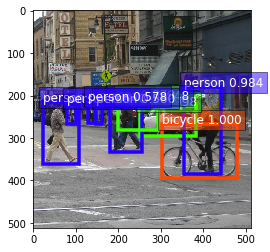

In [55]:
class_IDs, scores, bounding_boxes = deserialized_net(x)

ax = utils.viz.plot_bbox(img, bounding_boxes[0], scores[0],
                         class_IDs[0], class_names=net.classes)

In [58]:
ecr_image = "763104351884.dkr.ecr.us-east-1.amazonaws.com/mxnet-inference:1.6.0-cpu-py36-ubuntu16.04-v3.7"
ssd_predictor = deploy_model(model_data, "ssd-test", sagemaker_session, ecr_image, 'ml.m4.xlarge', "1.6.0", role, script="ssd_inference.py")

Deploying...
-----------------!
Endpoint Name: ssd-test-1605111422-5341


In [60]:
import cv2
img = cv2.imread('street_small.jpg')
%timeit output = ssd_predictor.predict(img)

5.59 s ± 147 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
ecr_image = "763104351884.dkr.ecr.us-east-1.amazonaws.com/mxnet-inference:1.6.0-cpu-py36-ubuntu16.04-v3.8"
mkl_ssd_predictor = deploy_model(model_data, "ssd-test", sagemaker_session, ecr_image, 'ml.m4.xlarge', "1.6.0", role, script="ssd_inference.py")

Deploying...
-------------------!
Endpoint Name: ssd-test-1605113432-1dc1


In [62]:
%timeit output = mkl_ssd_predictor.predict(img)

5.67 s ± 121 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# MASK - RCNN

In [3]:
model_name = 'mask_rcnn_resnet50_v1b_coco'
net = model_zoo.get_model(model_name, pretrained=True)
net.hybridize()
net(mx.nd.zeros((1, 3, 600, 956)))
net.export(model_name)

In [4]:
import tarfile
with tarfile.open("{}.tar.gz".format(model_name), "w:gz") as tar:
    tar.add("{}-0000.params".format(model_name))
    tar.add("{}-symbol.json".format(model_name))

In [5]:
im_fname = gcv_utils.download('https://github.com/dmlc/web-data/blob/master/' +
                          'gluoncv/detection/biking.jpg?raw=true',
                          path='biking.jpg')
x, orig_img = data.transforms.presets.rcnn.load_test(im_fname)
print('Shape of pre-processed image:', x.shape)

Shape of pre-processed image: (1, 3, 600, 956)


In [6]:
prefix = 'mask-rcnn-model'
model_data = sagemaker_session.upload_data(path="{}.tar.gz".format(model_name), key_prefix=prefix)

In [8]:
deserialized_net = mx.gluon.nn.SymbolBlock.imports("{}-symbol.json".format(model_name), ['data'], "{}-0000.params".format(model_name), ctx=mx.cpu(0))

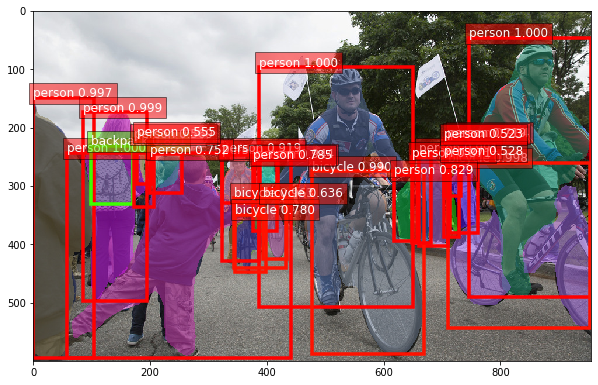

In [12]:
ids, scores, bboxes, masks = [xx[0].asnumpy() for xx in deserialized_net(x)]

# paint segmentation mask on images directly
width, height = orig_img.shape[1], orig_img.shape[0]
masks, _ = gcv_utils.viz.expand_mask(masks, bboxes, (width, height), scores)
orig_img = gcv_utils.viz.plot_mask(orig_img, masks)

# identical to Faster RCNN object detection
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax = gcv_utils.viz.plot_bbox(orig_img, bboxes, scores, ids,
                         class_names=net.classes, ax=ax)

In [16]:
ecr_image = "763104351884.dkr.ecr.us-east-1.amazonaws.com/mxnet-inference:1.6.0-cpu-py36-ubuntu16.04-v3.7"
mrcnn_predictor = deploy_model(model_data, "mrcnn-test", sagemaker_session, ecr_image, 'ml.m4.xlarge', "1.6.0", role, script="mask_rcnn_inference.py")

Deploying...
---------------!
Endpoint Name: mrcnn-test-1605118674-f850


In [20]:
import cv2 

img = cv2.imread('biking.jpg')
%timeit output = mrcnn_predictor.predict(img)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (413) from model with message "". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/mrcnn-test-1605118674-f850 in account 254243159864 for more information.